In [18]:
%%capture
%run final_chars_classification.ipynb



In [19]:
%run table_detector.ipynb

In [20]:
%run final_functions.ipynb

In [21]:
%run preprocessing.ipynb

In [22]:
%run get_rows_number.ipynb

./all_symbols/ 0
./all_symbols/( 70
./all_symbols/) 84
./all_symbols/+ 73
./all_symbols/A 76
./all_symbols/B 65
./all_symbols/C 79
./all_symbols/D 76
./all_symbols/E 71
./all_symbols/F 78
./all_symbols/implies 69
./all_symbols/xor 70
./all_symbols/~ 69


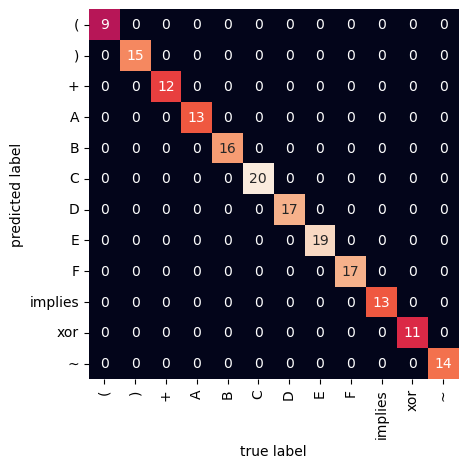

./0_1_symbols/ 0
./0_1_symbols/0 27
./0_1_symbols/1 27


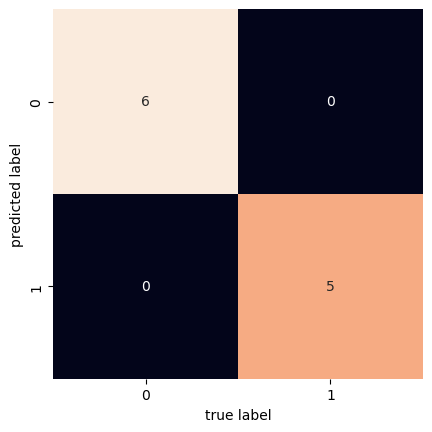

./letters_only_symbols/ 0
./letters_only_symbols/A 76
./letters_only_symbols/B 65
./letters_only_symbols/C 79
./letters_only_symbols/D 76
./letters_only_symbols/E 71
./letters_only_symbols/F 78


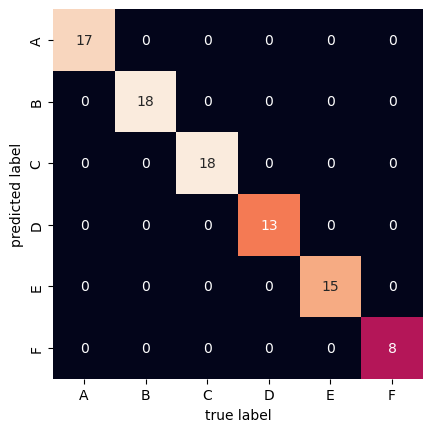

./E_F_symbols/ 0
./E_F_symbols/E 71
./E_F_symbols/F 78


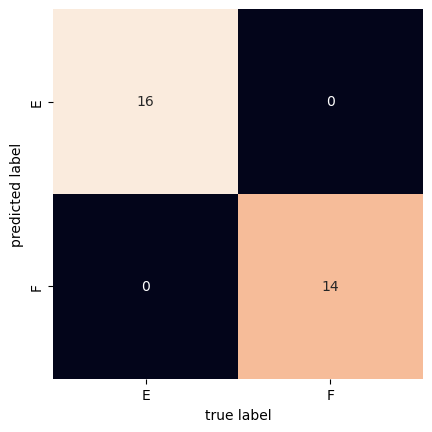

In [23]:
initialize_models(True)
load_models()

In [24]:
from tabular import tabular
import math

In [25]:
def solve_expression(img, is_table = False, showTrace = False):
    
    img = cv2.resize(img, (2448, 3264)) # size of A4
    img = img.astype(np.uint8)
    if(is_table):
        # show_images([table_tany(img)])
        # table_tany(img) 
        
        img = table_preprocessing(img, showTrace)
        if showTrace:
            show_images([img])

        cells, col_num, row_num = box_extraction(img, showTrace)#, table= True)

        letters = [classify(i, is_letter=True, is_table=is_table) for i in cells[0:col_num]]
        
        numbers = [classify(i, is_0_1=True, is_table=is_table) for i in cells[col_num:]]
        
        for i in  cells[col_num:]:
            show_images([i])
            print("out", classify(i, is_0_1=True, is_table=is_table))
        
        numbers = [int(i) for i in numbers]
        
        if True:
            print(letters)
            print(numbers)
            print('rows numbers ' + str(row_num))
            print('cols numbers ' + str(col_num))
        
        
        solver = tabular.McCluskey()
        num_outputs = col_num-int(math.log(row_num-1,2))
        print(f"num_outputs: {num_outputs}")
        solver.solve(cells=numbers, num_col=col_num, num_outputs=num_outputs)

    else: 

        img = expression_preprocessing(img, showTrace)
        if showTrace:
            show_images([img])

        expression_rows = get_rows_number(img, showTrace= showTrace)
        
        if showTrace:
            print("ROWS")
            show_images(expression_rows)
        expressions = [classify(i, is_expression=True, verbose=showTrace) for i in expression_rows ]
        
        if showTrace: print(expressions)
        result = []
        for ex in expressions:
            try:
                ex[1] ='='
                result.append(get_table(ex))
            except:
                result.append('error')
        
        for r in result:
            print(r)

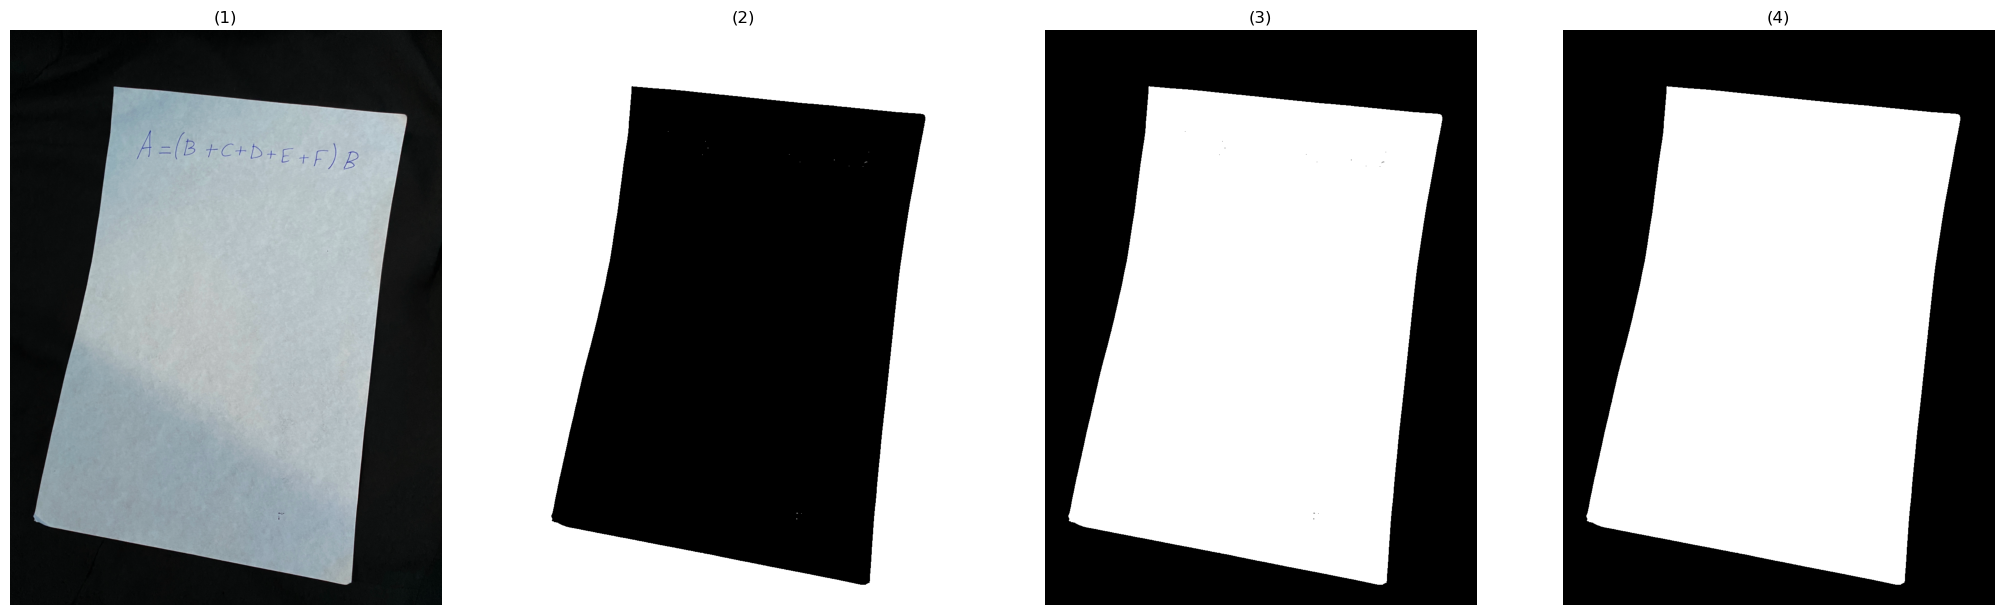

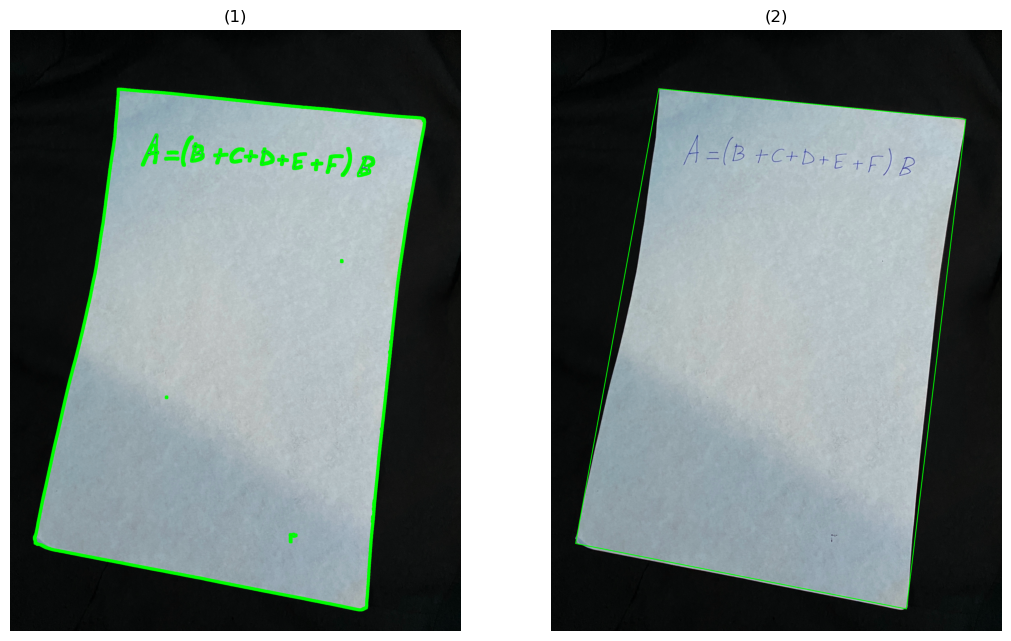

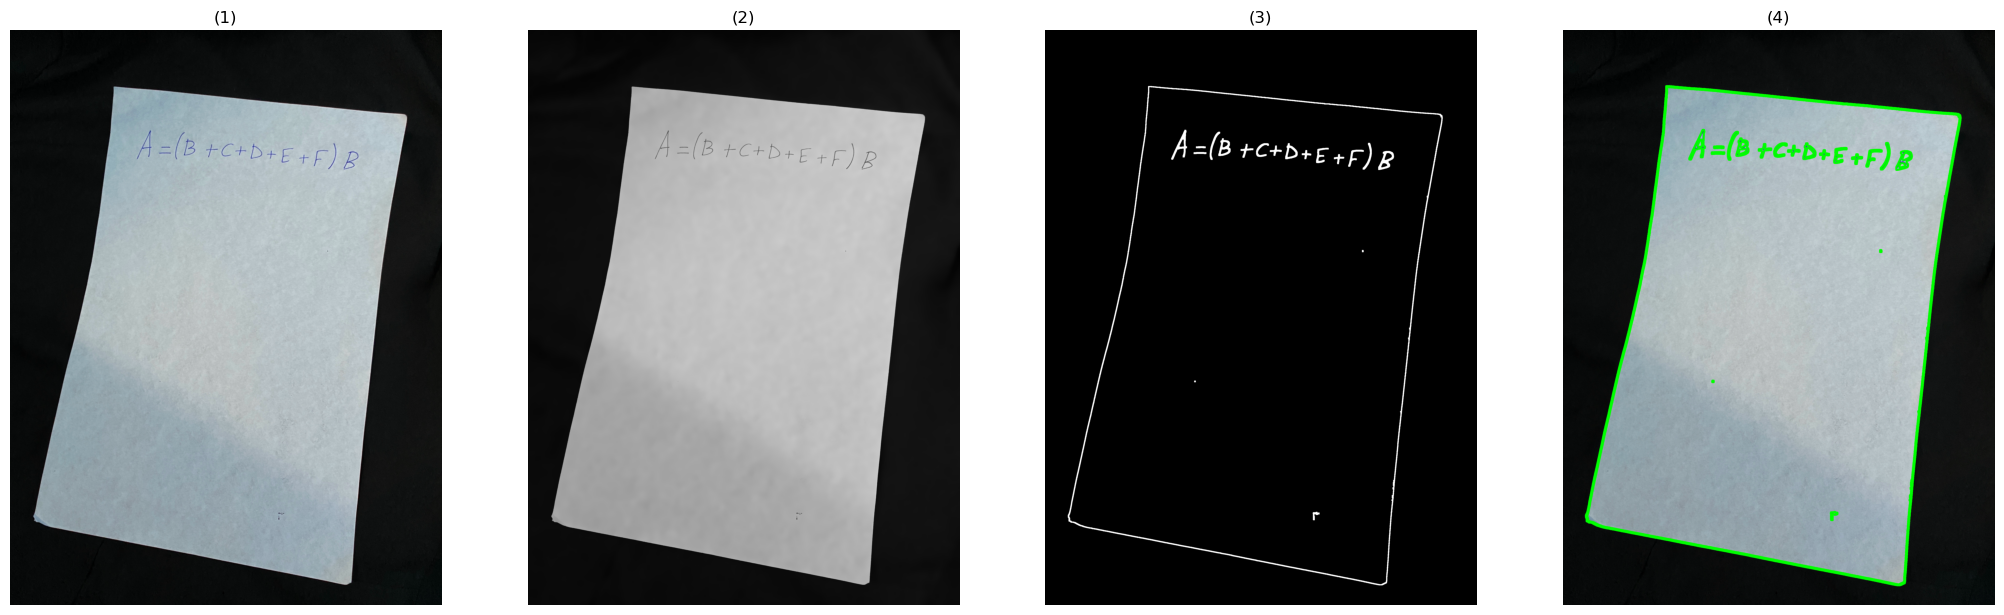

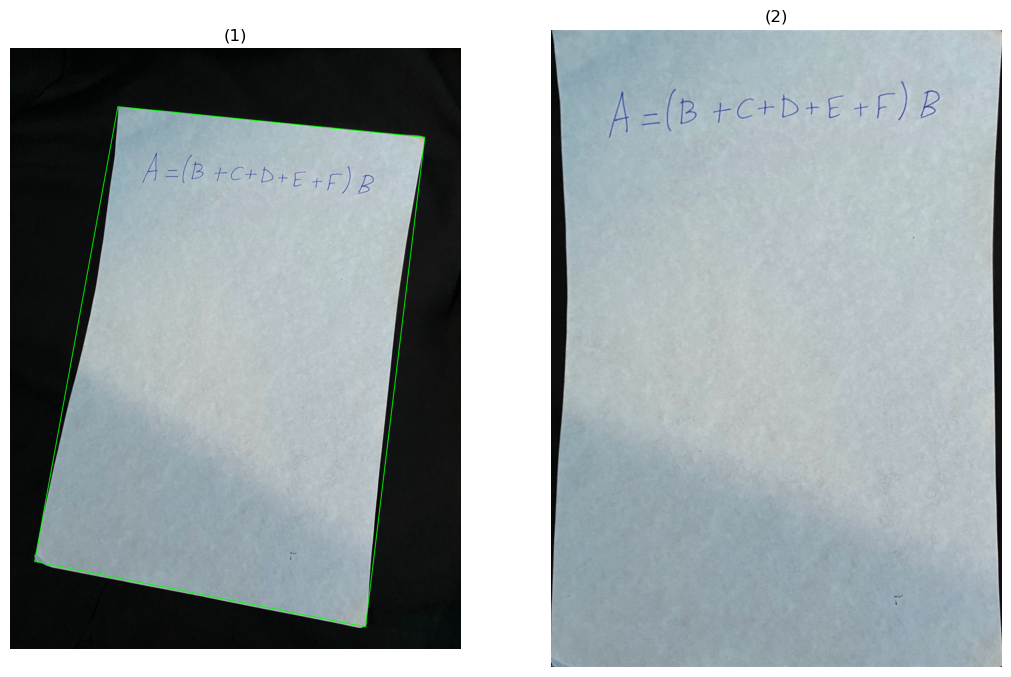

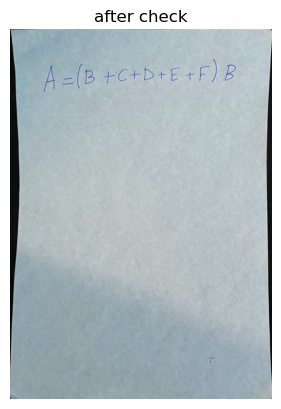

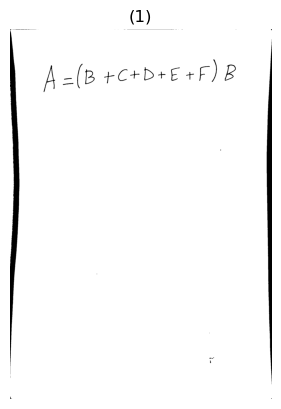

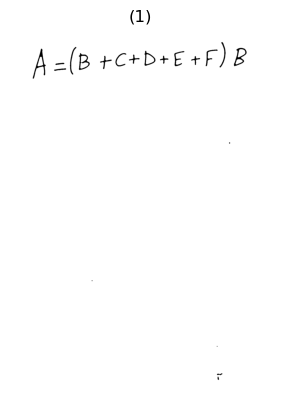

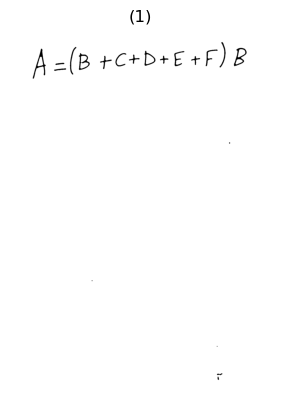

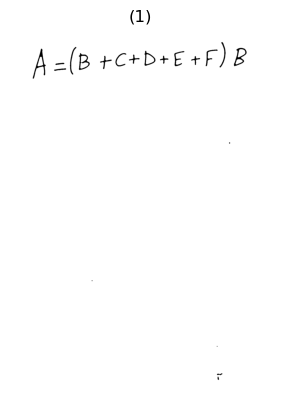

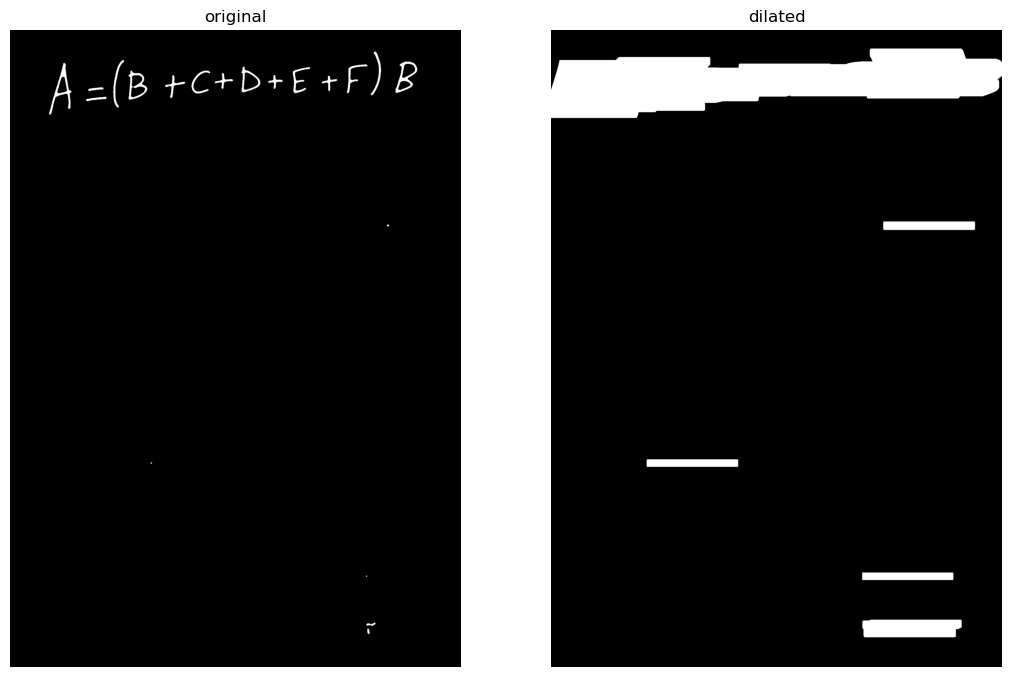

1
ROWS


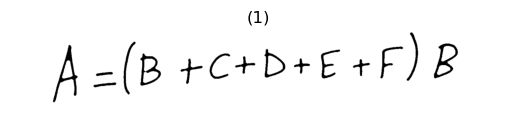

img shape: (282, 1830), max=255, min=0,median=255.0 and type uint8
tolerance: 91.5


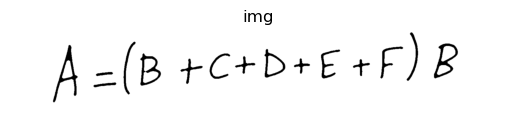

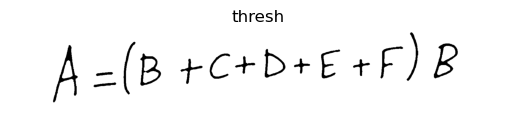

contours before area filtering
774.0, 600.5, -1671.5, -1115.5, -1584.0, 1047.5, 1534.0, -1374.5, 974.5, 1189.5, -2756.5, 1617.5, 6168.0, 2029.5, 5087.0, 1871.0, -1940.0, 5763.5, 6612.5, 1852.5, 1748.5, -513949.0, 
average_area 2591.3333333333335
max_width 93
max_height 212
contours after area filtering
19716, 1720, 1040, 8970, 9559, 7896, 7238, 5159, 8453, 3477, 7776, 4096, 10234, 8100, 11700, 
masks


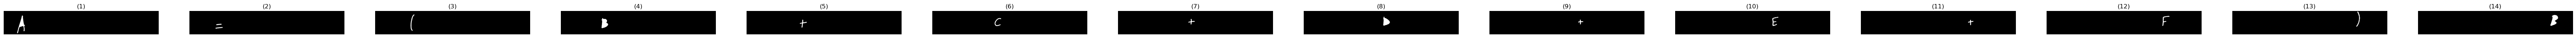

contours after merging


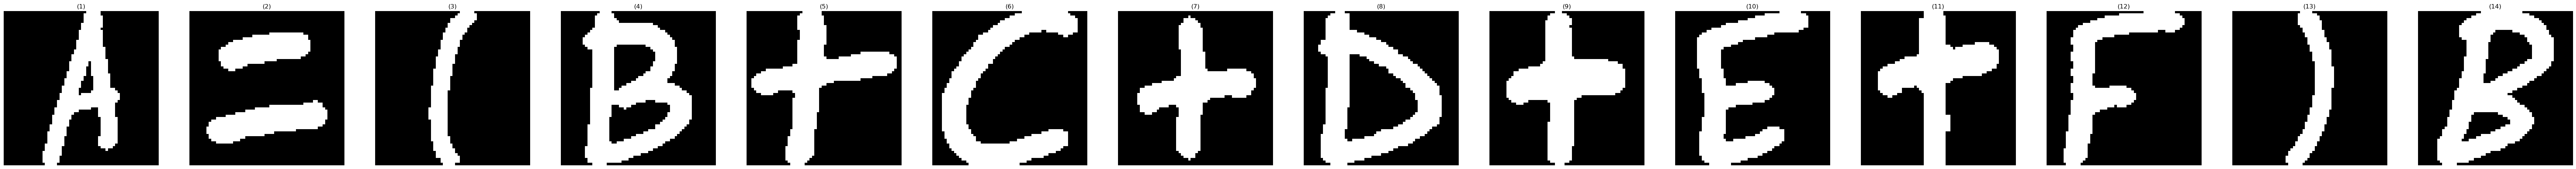

[array(['A', '~', '(', 'B', '+', 'C', '+', 'D', '+', 'E', '+', 'F', ')',
       'B'], dtype='<U7')]
( B or C or D or E or F ) and B 
+-----+-----+-----+-----+-----+------------------------------------+
|  B  |  C  |  E  |  D  |  F  |  ( B or C or D or E or F ) and B   |
|-----+-----+-----+-----+-----+------------------------------------|
|  1  |  1  |  1  |  1  |  1  |                 1                  |
|  1  |  1  |  1  |  1  |  0  |                 1                  |
|  1  |  1  |  1  |  0  |  1  |                 1                  |
|  1  |  1  |  1  |  0  |  0  |                 1                  |
|  1  |  1  |  0  |  1  |  1  |                 1                  |
|  1  |  1  |  0  |  1  |  0  |                 1                  |
|  1  |  1  |  0  |  0  |  1  |                 1                  |
|  1  |  1  |  0  |  0  |  0  |                 1                  |
|  1  |  0  |  1  |  1  |  1  |                 1                  |
|  1  |  0  |  1  |  1  |  0  |        

In [31]:
image = cv2.imread("./test_images/t13.jpg")

solve_expression(image, is_table=False, showTrace=True)




In [ ]:
# image = cv2.imread("./test_images/exs/t36.jpg") # TEST R
# image = cv2.imread("./test_images/exs/t35.jpg") # TEST R
# # image = cv2.imread("./test_images/exs/t40.jpg") # TEST R


# # image = cv2.imread("./test_images/exs/t34.jpg") # TEST R

# # image = cv2.imread("./test_images/exs/t33.jpg") 
# image = cv2.imread("./test_images/exs/t39.jpg") # TEST R
# # image = cv2.imread("./test_images/exs/t38.jpg") # TEST R

# result = solve_expression(image, is_table=True, showTrace=False)